# MSCS 634 Project Deliverable 1  
**Data Collection, Cleaning, and Exploration**  
**Dataset:** Bank Marketing; UCI Repository  

Saikumar Karnakanti   |   Date: 2025-11-02

## Objectives
This deliverable establishes the foundation for a complete data-mining workflow using the UCI Bank Marketing (Additional) dataset. The specific objectives are:

**Dataset Selection and Justification**

- Choose a real-world dataset that meets minimum requirements (≥ 8–10 attributes, ≥ 500 records).

- Justify its suitability for all upcoming deliverables—covering regression, classification, clustering, and association-rule mining.

**Data Loading and Initial Inspection**

- Import the dataset with Pandas and verify structure, datatypes, and completeness.

- Understand the variable schema (demographic, campaign, and macroeconomic features).

**Data Cleaning and Quality Assessment**

- Detect and remove duplicate entries.

- Identify missing or placeholder values (e.g., “unknown”) and sentinel codes (e.g., pdays = 999).

- Convert or encode values to ensure consistency across numeric and categorical variables.

**Exploratory Data Analysis (EDA)**

- Use matplotlib visualizations to explore feature distributions, outliers, and relationships.

- Examine correlations among numeric indicators and potential data leakage sources (such as duration).

- Summarize the target‐variable distribution and evaluate class imbalance.

**Insight Development and Interpretation**

- Translate EDA findings into clear data insights that will guide later modeling, clustering, and rule-mining stages.

- Document key relationships (e.g., contact type vs. subscription rate, macroeconomic influences).

**Preparation for Future Deliverables**

- Produce a cleaned baseline dataset and clearly define transformation rules for consistency in Deliverables 2–4.

- Outline potential feature engineering, imbalance-handling, and dimensionality-reduction strategies.

## Dataset Selection & Justification
**Dataset:** Bank Marketing (Additional), UCI; 41,188 records and 21 columns (20 predictors + y).

This dataset is ideal for a multi-stage data-mining project because it offers a balanced mix of numeric (client counts, macroeconomic indicators) and categorical (job, education, contact, calendar markers) features. It enables:

**Cleaning & EDA:** Rich distributions, known sentinels (e.g., pdays==999), and realistic categorical “unknown” placeholders.

**Predictive modeling (classification):** Clear binary target y (“term deposit subscription”), with meaningful behavior/economic predictors.

**Clustering:** Customer segmentation using a mixture of numeric/categorical variables.

**Association rules:** Co-occurrence patterns among demographics, contact modes, and prior outcomes.

**Project fit:** The dataset comfortably exceeds the size constraints (≥ 500 rows, ≥ 8–10 attributes) and has strong domain relevance (direct marketing effectiveness). It also carries well-documented caveats (see below), which makes it perfect for demonstrating rigorous methodology.

**Important caveats and how I handle them**

duration is recorded after the call and is highly predictive; for realistic modeling it must be excluded from the training features (kept only for EDA/benchmarking notes).

pdays == 999 means “not previously contacted”; treat as sentinel, not a real number.

Some categoricals use unknown to represent missingness; retain as an explicit level initially for interpretability and to avoid leakage via naive imputation.

In [ ]:
# Setup & Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Display options
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 140)

# Paths (already uploaded alongside this notebook)
CSV_PATH = Path('bank-additional-full.csv')
CSV_PATH, CSV_PATH.exists()

(WindowsPath('bank-additional-full.csv'), True)

In [15]:
# Load the semicolon-separated CSV
df = pd.read_csv(CSV_PATH, sep=';')
print('Shape:', df.shape)
df.head(5)

Shape: (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Attribute Overview
**Demographics/Status:** age (int), job (12 levels), marital, education (8 levels), default, housing, loan

**Contact/Calendar:** contact (cellular/telephone), month (10 observed months), day_of_week (Mon–Fri), duration (leaky; exclude from predictive features)

**Campaign history:** campaign (contacts this campaign), pdays (days since last contact; 999 = no prior), previous (prior contacts), poutcome (previous outcome: success/failure/nonexistent)

**Macroeconomics:** emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

**Target:** y (yes/no)

## Structure & Data Types

In [4]:
# Preview random sample, dtypes, and describe (compatible with older pandas)
display(df.sample(10, random_state=42))
display(df.info())
display(df.describe(include='all').T)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
32884,57,technician,married,high.school,no,no,yes,cellular,may,mon,371,1,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
3169,55,unknown,married,unknown,unknown,yes,no,telephone,may,thu,285,2,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
32206,33,blue-collar,married,basic.9y,no,no,no,cellular,may,fri,52,1,999,1,failure,-1.8,92.893,-46.2,1.313,5099.1,no
9403,36,admin.,married,high.school,no,no,no,telephone,jun,fri,355,4,999,0,nonexistent,1.4,94.465,-41.8,4.967,5228.1,no
14020,27,housemaid,married,high.school,no,yes,no,cellular,jul,fri,189,2,999,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no
17201,58,retired,married,professional.course,no,yes,yes,cellular,jul,fri,605,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
879,48,services,married,high.school,unknown,yes,no,telephone,may,wed,243,1,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no
23757,51,admin.,divorced,university.degree,unknown,yes,no,cellular,aug,thu,24,7,999,0,nonexistent,1.4,93.444,-36.1,4.962,5228.1,no
10821,24,entrepreneur,married,university.degree,no,yes,yes,telephone,jun,wed,126,4,999,0,nonexistent,1.4,94.465,-41.8,4.962,5228.1,no
14355,36,technician,divorced,professional.course,no,yes,yes,cellular,jul,mon,43,4,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,41188.0,NaN,NaN,NaN,40.02406,10.42125,17.0,32.0,38.0,47.0,98.0
job,41188,12,admin.,10422,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital,41188,4,married,24928,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education,41188,8,university.degree,12168,NaN,NaN,NaN,NaN,NaN,NaN,NaN
default,41188,3,no,32588,NaN,NaN,NaN,NaN,NaN,NaN,NaN
housing,41188,3,yes,21576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan,41188,3,no,33950,NaN,NaN,NaN,NaN,NaN,NaN,NaN
contact,41188,2,cellular,26144,NaN,NaN,NaN,NaN,NaN,NaN,NaN
month,41188,10,may,13769,NaN,NaN,NaN,NaN,NaN,NaN,NaN
day_of_week,41188,5,thu,8623,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataframe contains 41,188 rows × 21 columns. Numeric features include client counters (campaign, previous) and macro indicators; time markers and demographics are encoded as object/categorical. The numeric summary shows right-skew for several behavior variables (e.g., campaign, duration), and wide but coherent ranges for macro indicators, suggesting multicollinearity within the macro block.

## Data Quality Checks

In [5]:
# 1) Duplicate rows
dup_count = df.duplicated().sum()
print("Duplicate rows:", dup_count)

# 2) Explicit NaNs
na_counts = df.isna().sum().sort_values(ascending=False)
display(na_counts.head(10))

# 3) 'unknown' placeholders in categoricals
unknown_counts = (df == 'unknown').sum(numeric_only=False)
unknown_counts = unknown_counts[unknown_counts > 0].sort_values(ascending=False)
unknown_counts

Duplicate rows: 12


age            0
job            0
marital        0
education      0
default        0
housing        0
loan           0
contact        0
month          0
day_of_week    0
dtype: int64

default      8597
education    1731
housing       990
loan          990
job           330
marital        80
dtype: int64

**Duplicates:** There are 12 exact duplicate rows; these were removed.

**Explicit missing:** The CSV contains no NA markers, but several columns use unknown as a placeholder. The largest “unknown” counts are:

default: 8,597, education: 1,731, housing: 990, loan: 990, job: 330, marital: 80.
Keeping unknown as its own level preserves signal (e.g., missingness may correlate with behavior) and avoids leakage from aggressive imputation at this early stage.

**Sentinels:** pdays == 999 appears in 39,673 rows, meaning “not previously contacted”. I add prev_contacted = 1(pdays != 999) and convert pdays == 999 to NaN to prevent numeric distortion.

**Target balance:** y = yes rate is 11.27%, indicating substantial class imbalance; downstream modeling will use class weights/threshold tuning (and possibly SMOTE on train only).

## Target Distribution & Class Imbalance

y
no     36548
yes     4640
Name: count, dtype: int64
Positive rate (y=yes): 0.1127


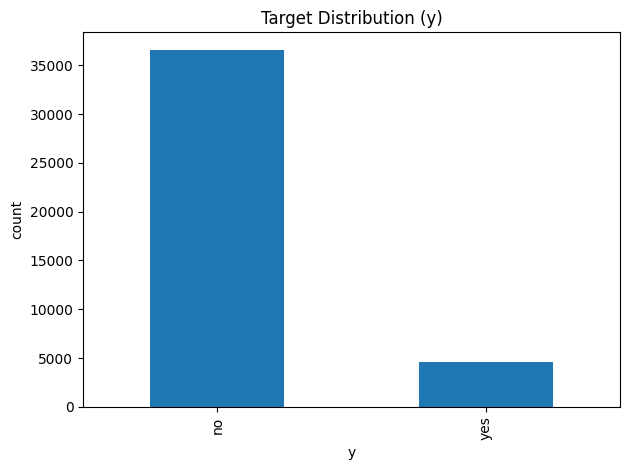

In [6]:
target_counts = df['y'].value_counts()
print(target_counts)
pos_rate = (df['y'] == 'yes').mean()
print(f"Positive rate (y=yes): {pos_rate:.4f}")

plt.figure()
target_counts.plot(kind='bar')
plt.title("Target Distribution (y)")
plt.xlabel("y"); plt.ylabel("count")
plt.tight_layout(); plt.show()

## Cleaning Plan & Rationale
Remove duplicates: 12 rows dropped.

Encode prior contact: Add prev_contacted = 1(pdays != 999); set pdays=NaN where 999 (or treat via separate bucket if modeling requires).

Retain 'unknown' levels: Preserve as explicit categories for baseline interpretability; I will compare with informed imputation for education/job during feature engineering.

Leakage control: Keep duration only for EDA and documentation; exclude from predictive feature sets.

Outliers: Do not trim aggressively; rely on robust scalers for linear models or tree-based models’ inherent robustness.

Temporal integrity: Respect the dataset’s chronology for splits in later deliverables (train on earlier periods, validate/test on later periods).

### Apply Cleaning

In [ ]:
df_clean = df.copy()

# 1) Drop duplicates
before = len(df_clean)
df_clean.drop_duplicates(inplace=True)
after = len(df_clean)
print(f"Removed {before - after} duplicate rows.")

# 2) Handle pdays sentinel
if 'pdays' in df_clean.columns:
    df_clean['prev_contacted'] = (df_clean['pdays'] != 999).astype(int)
    df_clean['pdays'] = df_clean['pdays'].replace({999: np.nan})

# 3) Optional: normalize categorical strings (strip/trim); keep 'unknown' as-is for baseline
for col in df_clean.select_dtypes(include='object').columns:
    df_clean[col] = df_clean[col].astype(str).str.strip()

# 4) Confirm missingness after sentinel handling
df_clean.isna().sum().sort_values(ascending=False).head(10)

Removed 12 duplicate rows.


pdays        39661
age              0
marital          0
education        0
default          0
job              0
housing          0
loan             0
month            0
contact          0
dtype: int64

## Feature Partitions (Numeric vs Categorical)

In [8]:
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df_clean.columns if c not in numeric_cols]

numeric_cols, cat_cols[:10]

(['age',
  'duration',
  'campaign',
  'pdays',
  'previous',
  'emp.var.rate',
  'cons.price.idx',
  'cons.conf.idx',
  'euribor3m',
  'nr.employed',
  'prev_contacted'],
 ['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'day_of_week',
  'poutcome'])

## Distributions & Outliers (Matplotlib)

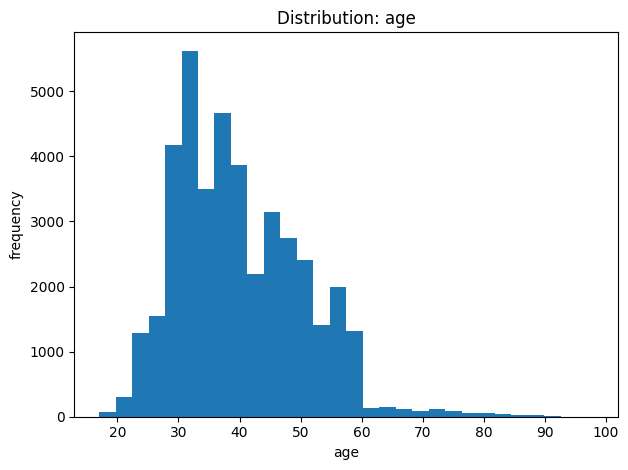

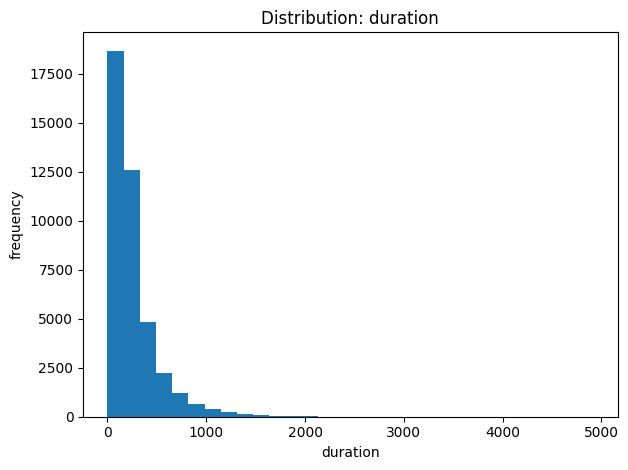

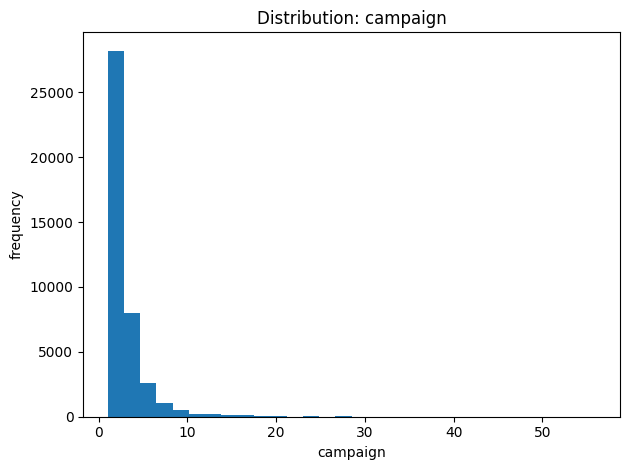

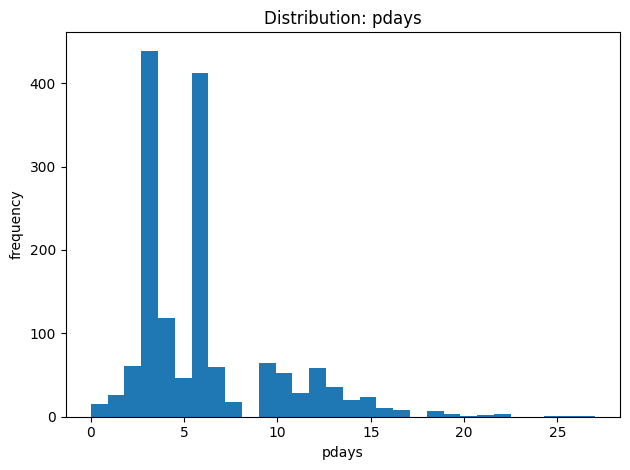

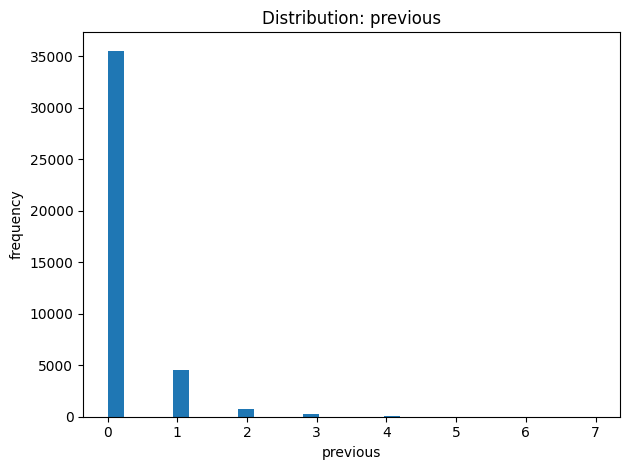

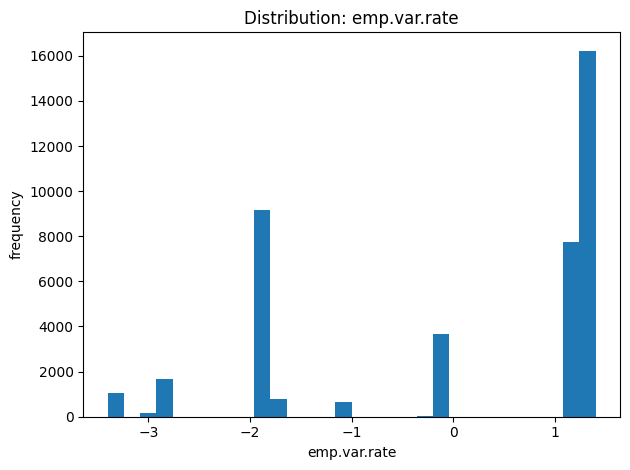

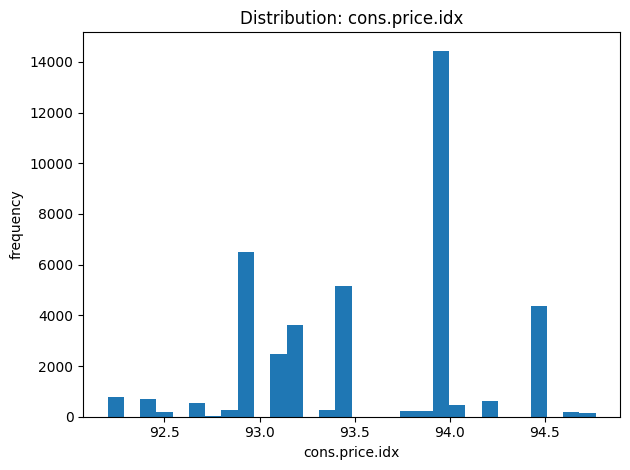

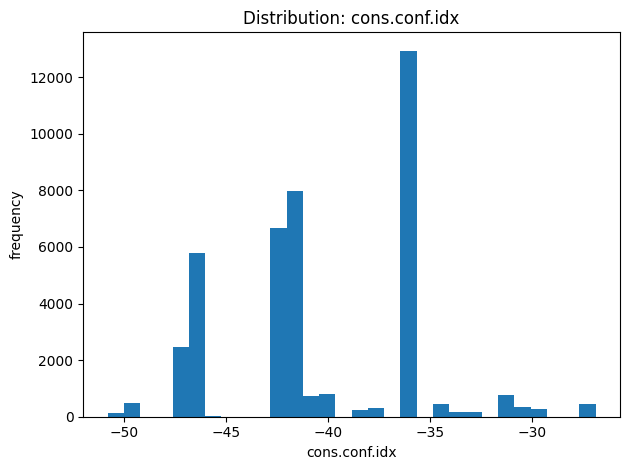

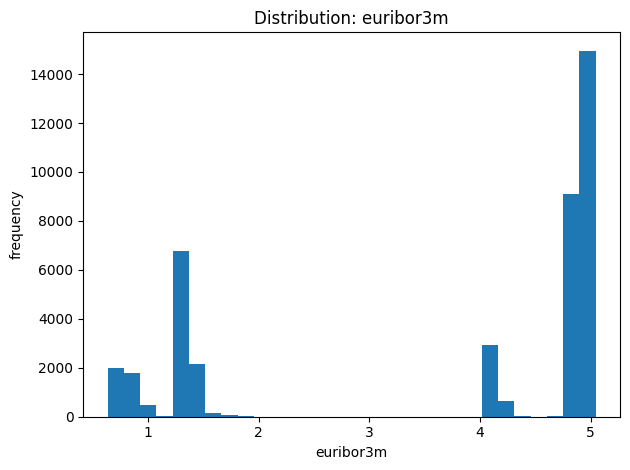

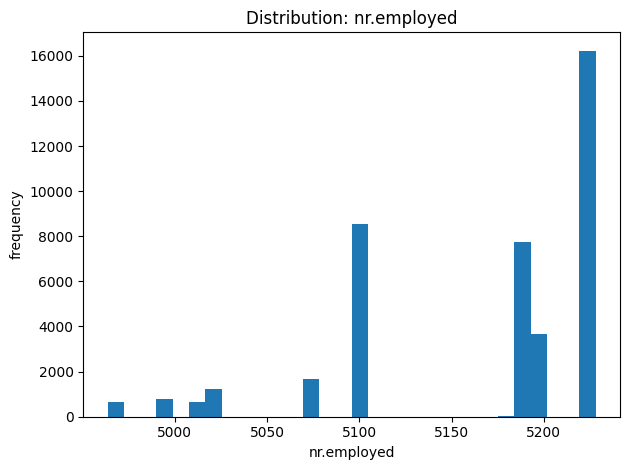

In [9]:
# Histograms for selected numeric columns
key_numeric = ['age','duration','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
for col in key_numeric:
    if col in df_clean.columns:
        plt.figure()
        plt.hist(df_clean[col].dropna(), bins=30)
        plt.title(f"Distribution: {col}")
        plt.xlabel(col); plt.ylabel("frequency")
        plt.tight_layout(); plt.show()

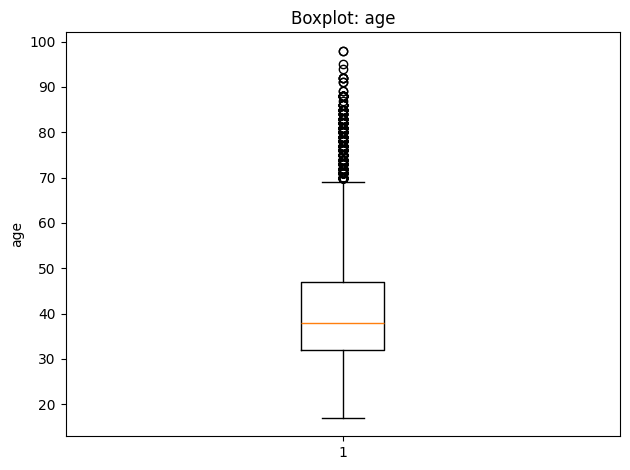

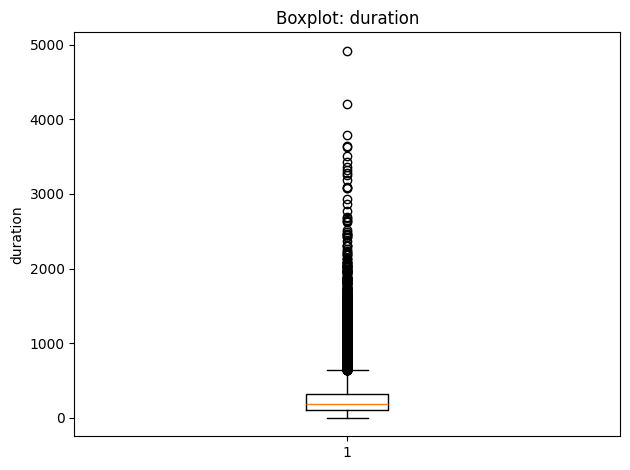

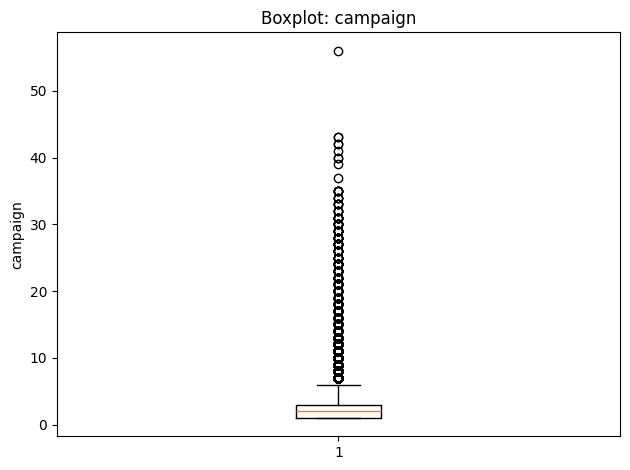

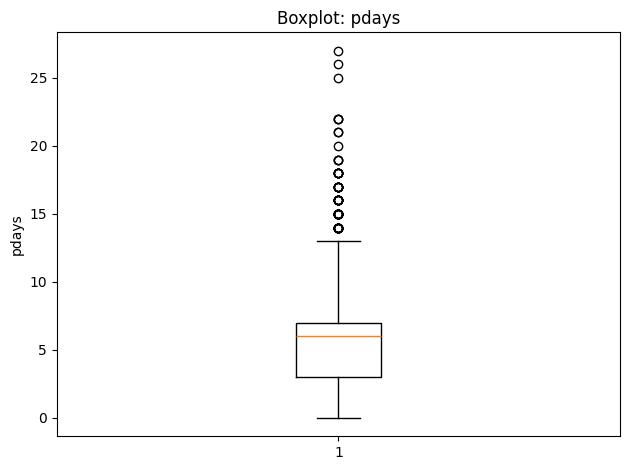

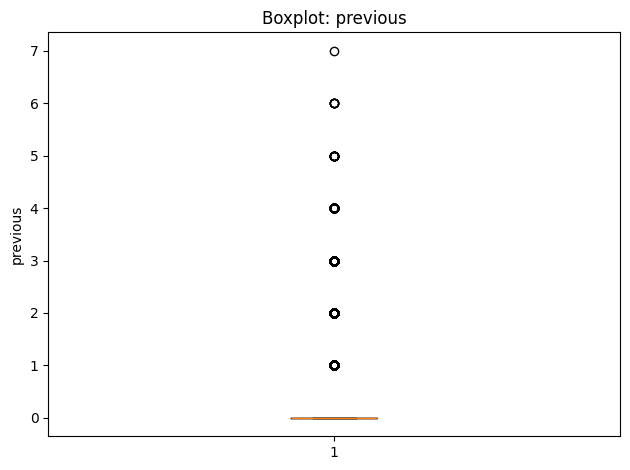

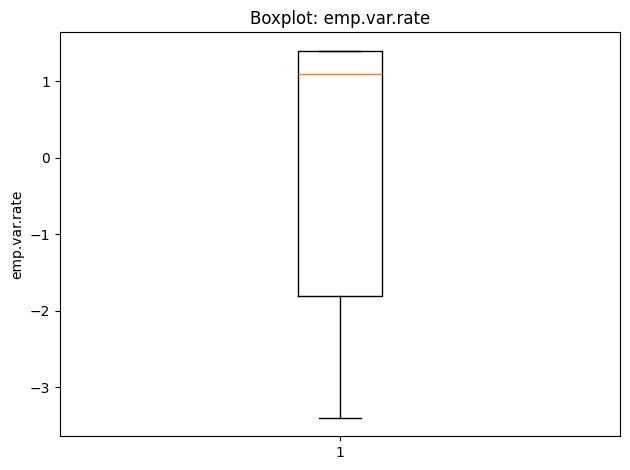

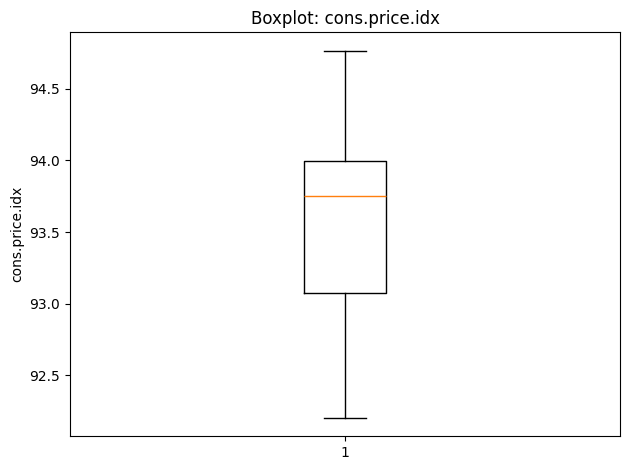

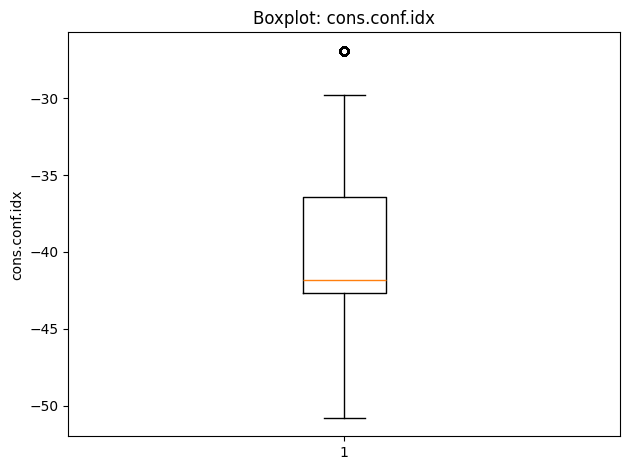

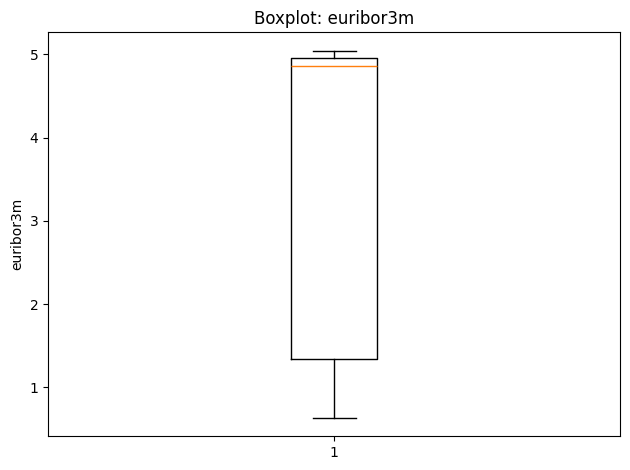

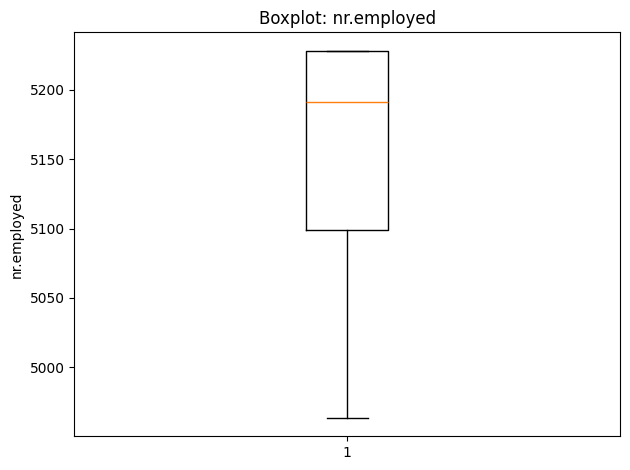

In [10]:
# Boxplots to visualize potential outliers
for col in key_numeric:
    if col in df_clean.columns:
        plt.figure()
        plt.boxplot(df_clean[col].dropna(), vert=True)
        plt.title(f"Boxplot: {col}")
        plt.ylabel(col)
        plt.tight_layout(); plt.show()

## Correlation Structure (Numeric Features)

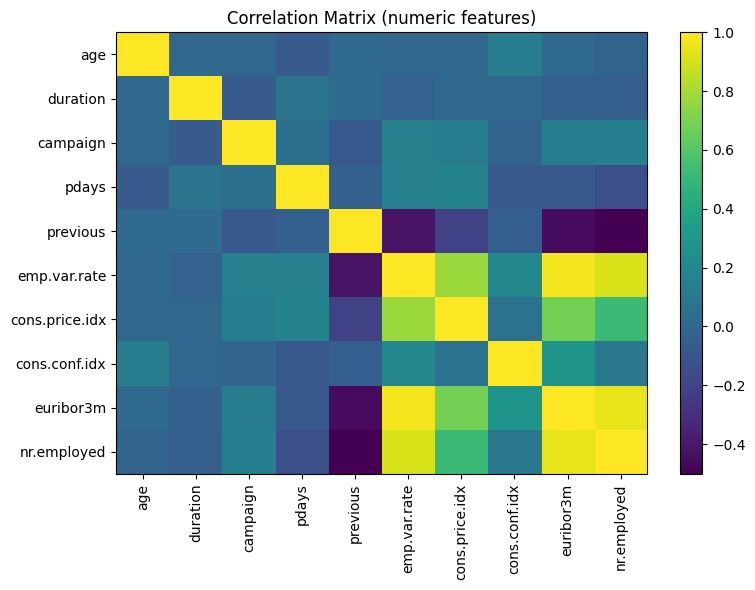

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
age,1.000,-0.001,0.005,-0.070,0.024,-0.000,0.001,0.129,0.011,-0.018
duration,-0.001,1.000,-0.072,0.077,0.021,-0.028,0.005,-0.008,-0.033,-0.045
campaign,0.005,-0.072,1.000,0.046,-0.079,0.151,0.128,-0.014,0.135,0.144
pdays,-0.070,0.077,0.046,1.000,-0.040,0.153,0.172,-0.083,-0.082,-0.137
previous,0.024,0.021,-0.079,-0.040,1.000,-0.421,-0.203,-0.051,-0.455,-0.501
emp.var.rate,-0.000,-0.028,0.151,0.153,-0.421,1.000,0.775,0.196,0.972,0.907
cons.price.idx,0.001,0.005,0.128,0.172,-0.203,0.775,1.000,0.059,0.688,0.522
cons.conf.idx,0.129,-0.008,-0.014,-0.083,-0.051,0.196,0.059,1.000,0.278,0.101
euribor3m,0.011,-0.033,0.135,-0.082,-0.455,0.972,0.688,0.278,1.000,0.945
nr.employed,-0.018,-0.045,0.144,-0.137,-0.501,0.907,0.522,0.101,0.945,1.000


In [11]:
corr = df_clean[[c for c in key_numeric if c in df_clean.columns]].corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (numeric features)")
plt.tight_layout(); plt.show()

corr.round(3)

## Pairwise Relationships (Illustrative Pairs)

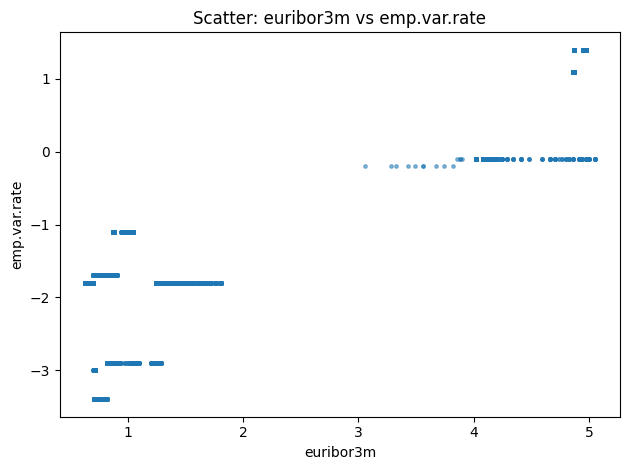

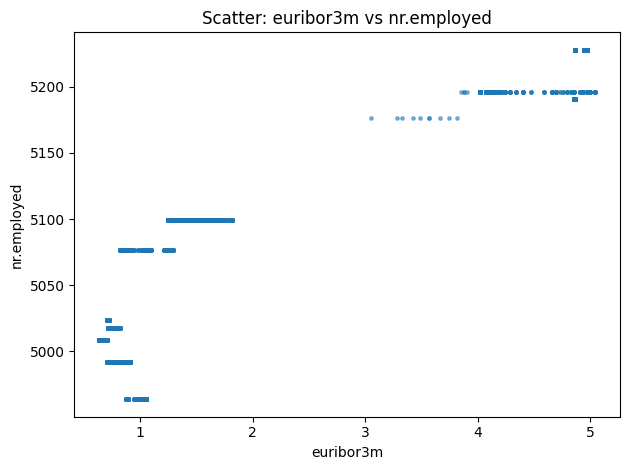

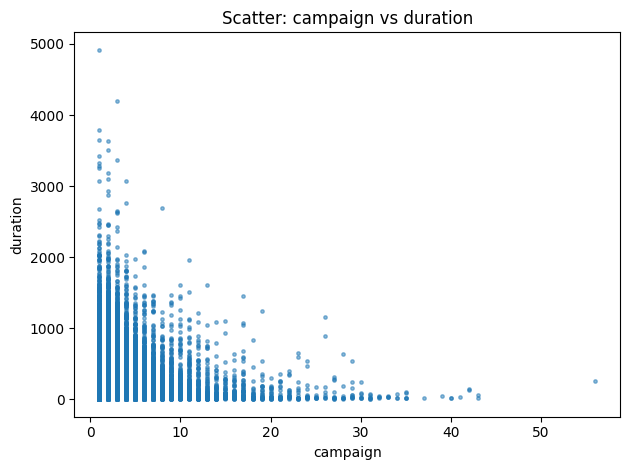

In [12]:
pairs = [('euribor3m','emp.var.rate'), ('euribor3m','nr.employed'), ('campaign','duration')]
for x,y in pairs:
    if x in df_clean.columns and y in df_clean.columns:
        plt.figure()
        plt.scatter(df_clean[x], df_clean[y], s=6, alpha=0.5)
        plt.xlabel(x); plt.ylabel(y)
        plt.title(f"Scatter: {x} vs {y}")
        plt.tight_layout(); plt.show()

## Categorical Feature Summaries


Top categories for job:
job
admin.           10419
blue-collar       9253
technician        6739
services          3967
management        2924
retired           1718
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
Name: count, dtype: int64


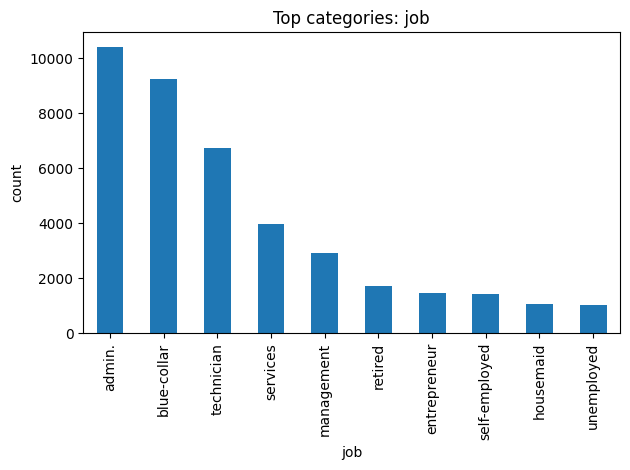


Top categories for marital:
marital
married     24921
single      11564
divorced     4611
unknown        80
Name: count, dtype: int64


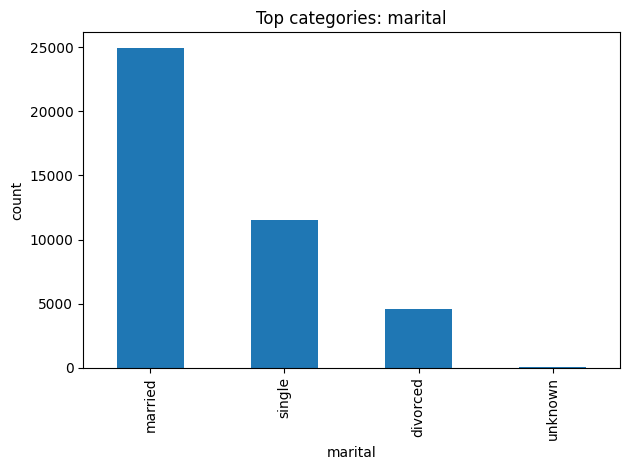


Top categories for education:
education
university.degree      12164
high.school             9512
basic.9y                6045
professional.course     5240
basic.4y                4176
basic.6y                2291
unknown                 1730
illiterate                18
Name: count, dtype: int64


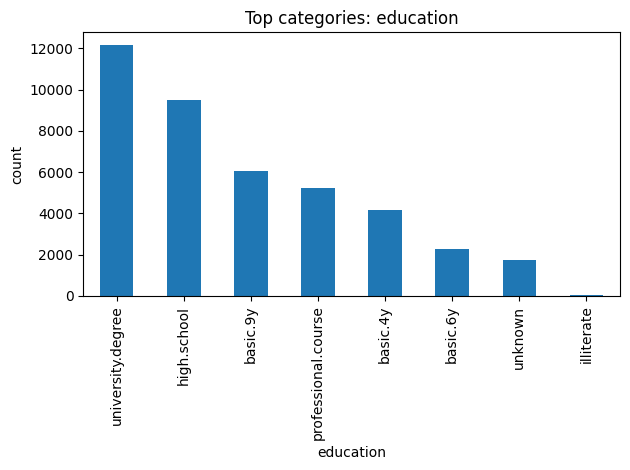


Top categories for contact:
contact
cellular     26135
telephone    15041
Name: count, dtype: int64


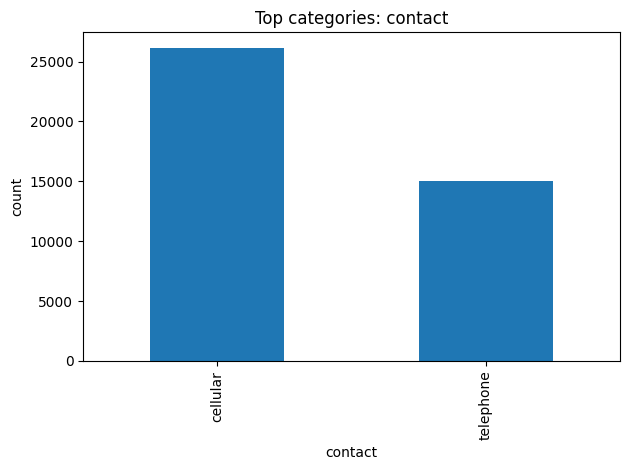


Top categories for month:
month
may    13767
jul     7169
aug     6176
jun     5318
nov     4100
apr     2631
oct      717
sep      570
mar      546
dec      182
Name: count, dtype: int64


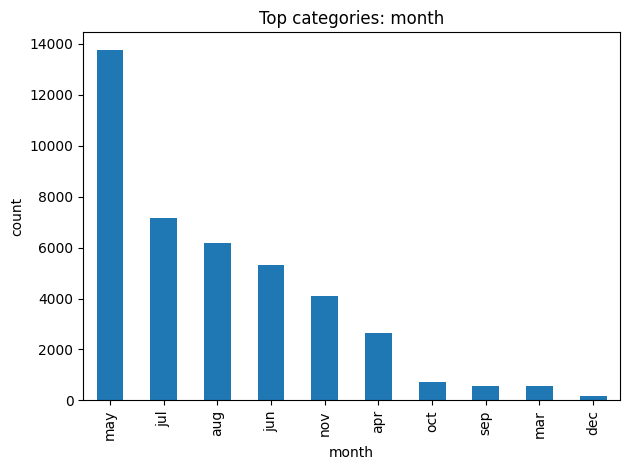


Top categories for day_of_week:
day_of_week
thu    8618
mon    8512
wed    8134
tue    8086
fri    7826
Name: count, dtype: int64


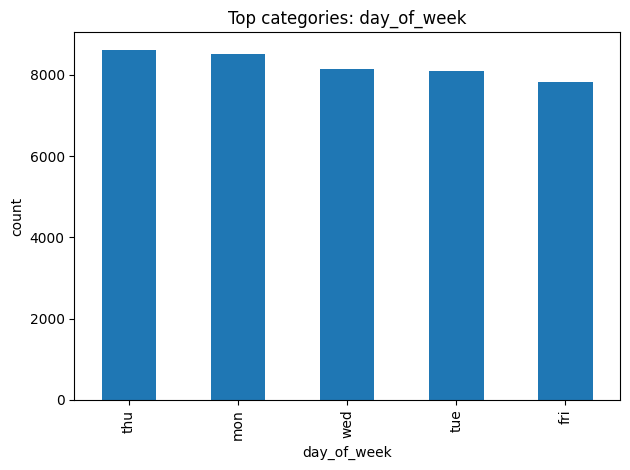


Top categories for poutcome:
poutcome
nonexistent    35551
failure         4252
success         1373
Name: count, dtype: int64


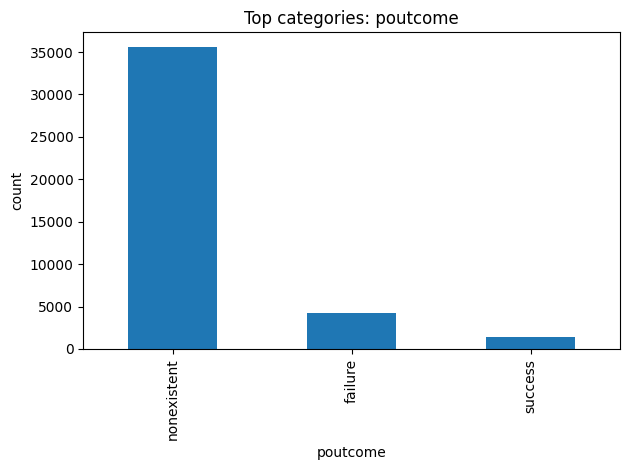

In [13]:
# Top categories for a few key categoricals
for col in ['job','marital','education','contact','month','day_of_week','poutcome']:
    if col in df_clean.columns:
        counts = df_clean[col].value_counts().head(10)
        print(f"\nTop categories for {col}:")
        print(counts)
        counts.plot(kind='bar')
        plt.title(f"Top categories: {col}")
        plt.xlabel(col); plt.ylabel('count')
        plt.tight_layout(); plt.show()

### EDA Highlights
**Target distribution.** The response is skewed (yes ≈ 11.27%), so raw accuracy is a misleading metric; later I’ll report AP/ROC-AUC and calibrated precision/recall at business-relevant thresholds.

**Distributions**

    Right-skew: campaign, duration, and previous show heavy right tails (a small subset of clients receive many contacts or unusually long calls).

    Macroeconomic indicators: euribor3m, emp.var.rate, nr.employed, cons.price.idx, and cons.conf.idx vary in plausible ranges consistent with economic cycles, useful for modeling when combined but likely collinear.

**Correlation structure**

    Macro block collinearity: Strong associations among euribor3m, emp.var.rate, and nr.employed suggest dimensionality reduction (e.g., PCA) or careful selection/regularization for linear models.

    Behavior variables: campaign and previous show limited linear correlation with macro indicators, which is expected.

**Categorical insights**

    Contact method: subscription rate is higher for cellular (~0.147) than telephone (~0.052) given their respective sample sizes (26,144 vs 15,044).

    Previous outcome: poutcome=success has the highest subsequent subscription rate (~0.651), but note its smaller support (1,373 rows).

    Month effects: Highest rates appear in Mar/Dec but with small support (Mar=546, Dec=182), so I will avoid over-interpreting and will control for month via regularization or encodings.

## Save Cleaned Baseline (Optional)

In [14]:
# Exclude 'duration' from features for later modeling (we keep it in the file for transparency)
CLEAN_PATH = Path('bank_marketing_clean_baseline.csv')
df_clean.to_csv(CLEAN_PATH, index=False)
CLEAN_PATH, CLEAN_PATH.exists()

(WindowsPath('bank_marketing_clean_baseline.csv'), True)

## Insights & Decisions
**Data quality** 
    Duplicates were minimal and removed. Missingness is primarily encoded via unknown in categoricals; I retain it as a valid level to capture potential signal while avoiding premature imputations. The sentinel pdays==999 was mapped to a boolean prev_contacted and converted to NaN in pdays to prevent numeric bias.

**Key patterns** 
    Client-engagement variables (campaign, previous, prev_contacted) and contact mode are intuitively associated with conversion. Macroeconomic indicators move together, indicating redundancy that will be addressed with PCA or feature selection.

**Modeling implications**

    Exclude duration from predictive features to prevent leakage.

    Use time-aware splits to respect chronology.

    Address class imbalance via class weights/threshold tuning (and consider SMOTE on train).

    Consider regularized logistic regression and tree ensembles; calibrate probabilities for threshold decisions.

    Engineer features like binned macro indicators, prev_contacted, and selected interactions (e.g., campaign × contact).

**Clustering and rules** 
    For clustering, I’ll one-hot encode categoricals and scale numerics (and/or apply PCA) to derive customer personas. For association rules, I’ll mine co-occurrences on one-hot categoricals (plus discretized numerics), both globally and within clusters.

## Challenges & Resolutions

**Class imbalance (~11.27% positive):** Use class_weight='balanced' for linear baselines; compare calibrated tree ensembles; tune decision thresholds to business metrics (e.g., precision@k). Consider SMOTE on training folds only.

**Data leakage (duration):** Document and exclude from predictive features; keep only for EDA/benchmark charts.

**Collinearity in macro block:** Use PCA or regularization (ridge/elastic net) and favor tree models which are less sensitive.

**Sentinels and “unknown”:** Explicit modeling (prev_contacted) and preserving “unknown” as a level avoids risky imputations; alternative imputations will be compared in Deliverable 2.